# Семинар 3 - Ambrosia

Библиотека покрывает основные этапы в АБ тестировании:
- Подготовка данных (Preprocessing)
- Дизайн эксперимента (Designer)
- Деление объектов по группам (Splitter)
- Оценка результатов эксперимента после его завершения (Tester)

Все идет вокруг оценки разности средних (t-test используется как критерий по умолчанию), но есть поддержка Mann–Whitney и bootstrap

In [1]:
import scipy
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm.auto import tqdm

from ambrosia.preprocessing import (Preprocessor, AggregatePreprocessor, RobustPreprocessor,
                                    IQRPreprocessor, LogTransformer,
                                    BoxCoxTransformer)
from ambrosia.designer import Designer, design
from ambrosia.splitter import Splitter, split
from ambrosia.tester import Tester, test

## Данные

In [2]:
# 'https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip'
# 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
DATA_PATH = Path("data_original")

In [3]:
interactions = pd.read_csv(DATA_PATH / 'interactions.csv')
users = pd.read_csv(DATA_PATH / 'users.csv')
items = pd.read_csv(DATA_PATH / 'items.csv')

In [4]:
# предобработка данных
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).dt.date
# interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


In [5]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


In [7]:
# выделим данные за одну (последнюю) неделю
week1_orig = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)].copy()

## Preprocessing

В Ambrosia есть scikit-learn like трансформеры для предобработки данных.

Примеры из репы - [MobileTeleSystems/Ambrosia 1](https://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/00_preprocessing.ipynbhttps://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/00_preprocessing.ipynb), [MobileTeleSystems/Ambrosia 2](https://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/02_preprocessor.ipynbhttps://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/02_preprocessor.ipynb)

In [8]:
aggregator = AggregatePreprocessor(categorial_method='mode', real_method='sum')
week1_agg = aggregator.fit_transform(dataframe=week1_orig, groupby_columns='user_id', real_cols=['total_dur'])

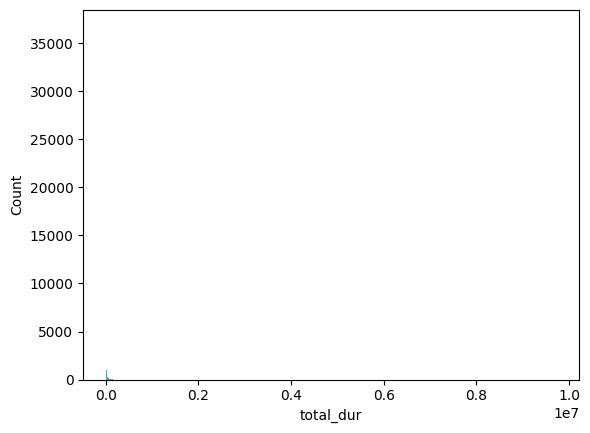

In [9]:
ax = sns.histplot(week1_agg['total_dur'])

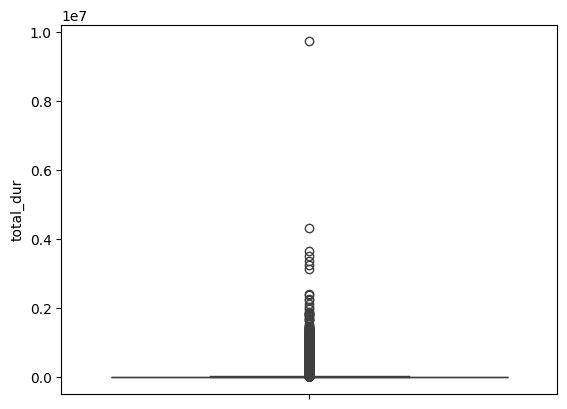

In [10]:
ax = sns.boxplot(week1_agg['total_dur'])

In [11]:
iqr_transformer = IQRPreprocessor()
week1_iqr = iqr_transformer.fit_transform(dataframe=week1_agg, column_names=['total_dur'])

ambrosia LOGGER: Making IQR transformation of columns ['total_dur']
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean total_dur: 17860.0928 ===> 7117.3791
ambrosia LOGGER: Change Variance total_dur: 3923731565.8647 ===> 72851604.7364
ambrosia LOGGER: Change IQR total_dur: 14422.5000 ===> 9627.0000
ambrosia LOGGER: Change Range total_dur: 9731800.0000 ===> 36897.0000


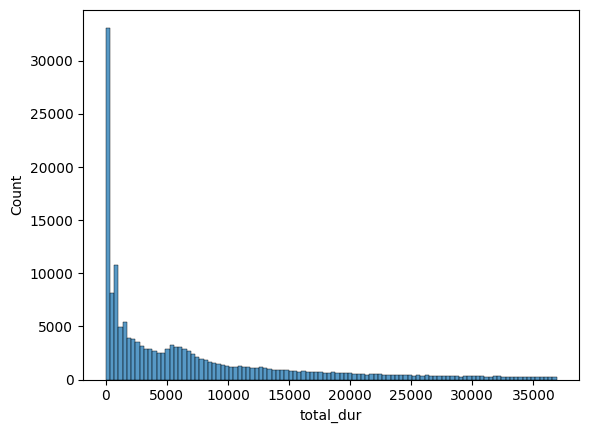

In [12]:
ax = sns.histplot(week1_iqr['total_dur'])

In [13]:
robust_transformer = RobustPreprocessor()
week1_rob = robust_transformer.fit_transform(dataframe=week1_agg, column_names='total_dur', alpha=0.025, tail='right')

ambrosia LOGGER: Making right-tail robust transformation of columns ['total_dur']
                 with alphas = [0.025]
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean total_dur: 17860.0928 ===> 11591.6125
ambrosia LOGGER: Change Variance total_dur: 3923731565.8647 ===> 315389652.7180
ambrosia LOGGER: Change IQR total_dur: 14422.5000 ===> 13098.5000
ambrosia LOGGER: Change Range total_dur: 9731800.0000 ===> 110530.0000


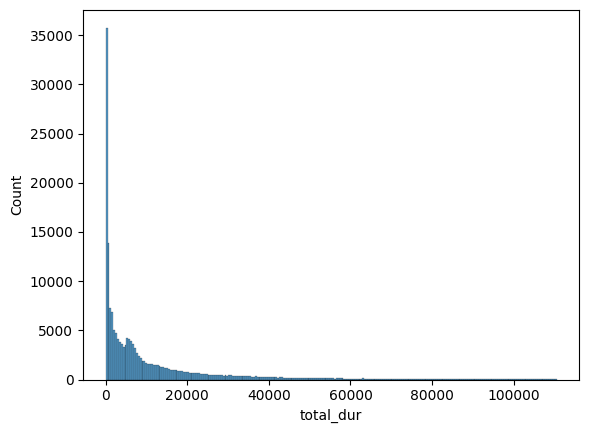

In [14]:
ax = sns.histplot(week1_rob['total_dur'])

Для дальнейших вычислений пойдет результат от `RobustPreprocessor`, реализуем это через `Preprocessor` и потом дополнительно прологарифмируем "таргет"

In [15]:
preprocessor = Preprocessor(dataframe=week1_orig, verbose=True)

week1 = (preprocessor
         .aggregate(groupby_columns='user_id', agg_params={'total_dur': 'sum'})
         .robust(['total_dur'], alpha=0.025, tail='right')
         .data())

ambrosia LOGGER: Making right-tail robust transformation of columns ['total_dur']
                 with alphas = [0.025]
ambrosia LOGGER: 

ambrosia LOGGER: Change Mean total_dur: 17860.0928 ===> 11591.6125
ambrosia LOGGER: Change Variance total_dur: 3923731565.8647 ===> 315389652.7180
ambrosia LOGGER: Change IQR total_dur: 14422.5000 ===> 13098.5000
ambrosia LOGGER: Change Range total_dur: 9731800.0000 ===> 110530.0000


In [16]:
week1['total_dur_ln'] = np.log2(week1['total_dur'])

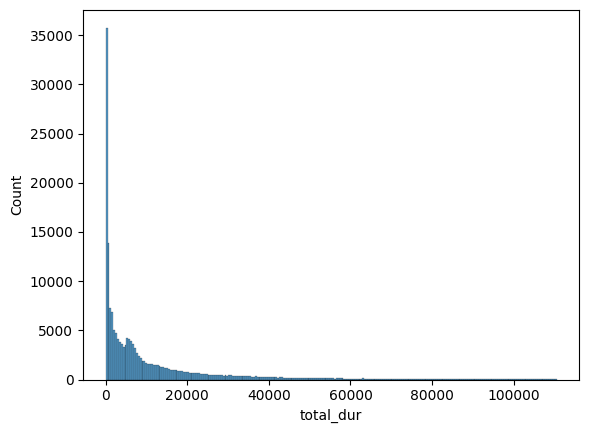

In [17]:
ax = sns.histplot(week1['total_dur'])

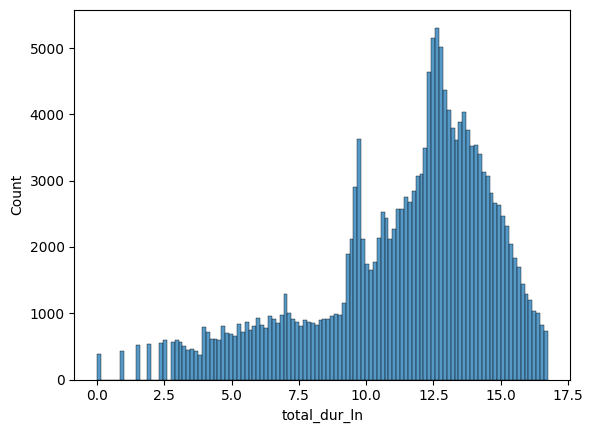

In [18]:
ax = sns.histplot(week1['total_dur_ln'])

## Designer

4 основных параметра АБ теста:
- **I type error** (alpha) - вероятность найти эффект, когда его нет\
1 - alpha это *корректность или значимость*
- **II type error** (beta) - вероятность не найти эффект, когда он есть\
1 - beta это *мощность*
- **Groups sizes** - размер групп 
- **Minimal detectable effect** (MDE) - минимальный эффект, который мы можем поймать при заданных уровнях мощности и корректности

Разберем первый шаг - дизайн, представленный классом [Designer](https://ambrosia.readthedocs.io/en/latest/ambrosia_elements/designer.htmlhttps://ambrosia.readthedocs.io/en/latest/ambrosia_elements/designer.html)

Примеры из репы - [MobileTeleSystems/Ambrosia](https://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/03_pandas_designer.ipynbhttps://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/03_pandas_designer.ipynb)

In [19]:
designer = Designer(dataframe=week1, metrics='total_dur_ln')
designer_raw = Designer(dataframe=week1, metrics='total_dur')

In [20]:
first_type_errors = [0.01, 0.05]
second_type_errors = [0.1, 0.2]
designer.set_first_errors(first_type_errors)
designer.set_second_errors(second_type_errors)
designer_raw.set_first_errors(first_type_errors)
designer_raw.set_second_errors(second_type_errors)

In [21]:
effects = [1.01, 1.03, 1.05]

Про `method`:
- `theory` - асимптотические формулы для t-test для средних. Описание тут - [habr](https://habr.com/ru/companies/ru_mts/articles/700992/)
- `empiric` - оценка через сэмплирование групп для указанного критерия через `criterion`
- `binary` - для 0/1 таргета

Возможные значения `criterion`: `ttest`, `mw`, `bootstrap`

Алгоритм применения от разработчиков:
```
Применить theory сначала (это быстро). Если он выдает небольшое число типо 10_000, то можно попробовать empiric для более точной оценки. 
Если 150_000, то empiric скорее всего будет тупить, так как ему в какой-то момент придется семплировать 100 выборок размера 150_000, а если bootstrap то так еще 100 раз (-_-) 
Но если размер выборок большой, то можно положиться на предельные теоремы в теоретическом подходе и поверить ему.
```

In [22]:
designer_raw.run(to_design='size', method='theory', effects=effects)

"Errors ($\alpha$, $\beta$)",(0.01; 0.1),(0.01; 0.2),(0.05; 0.1),(0.05; 0.2)
Effect,,,,
1.0%,698519,548275,493275,368469
3.0%,77615,60921,54810,40942
5.0%,27943,21933,19732,14740


In [23]:
designer.run(to_design='size', method='theory', effects=effects)

"Errors ($\alpha$, $\beta$)",(0.01; 0.1),(0.01; 0.2),(0.05; 0.1),(0.05; 0.2)
Effect,,,,
1.0%,26197,20563,18500,13819
3.0%,2913,2287,2057,1537
5.0%,1050,825,741,554


Теоритические числа вдохновляют, теперь оценим через Манна-Уитни

In [24]:
designer.run(to_design='size', method='empiric', criterion='mw', effects=effects, bs_samples=100, n_jobs=8)

Group sizes calculation:   0%|          | 0/12 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.01, 0.1)","(0.01, 0.2)","(0.05, 0.1)","(0.05, 0.2)"
Effect,,,,
1.0%,14989,11944,11585,8701
3.0%,1678,1344,1066,817
5.0%,565,489,442,421


Оценим добавление эффекта не через constant (по умолчанию), а через нормальное распределение N(delta, небольшая дисперсия)

In [25]:
designer.run(to_design='size', method='empiric', criterion='mw', injection_method='normal', effects=effects, bs_samples=100, n_jobs=8)

Group sizes calculation:   0%|          | 0/12 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.01, 0.1)","(0.01, 0.2)","(0.05, 0.1)","(0.05, 0.2)"
Effect,,,,
1.0%,20521,16076,12584,9425
3.0%,2335,1617,1508,1077
5.0%,790,665,545,399


Размеры групп оценили, теперь попробуем зайти с другой стороны - оценить эффект в зависимости от размера групп

In [26]:
sizes = [1_000, 10_000, 20_000]

designer.run(to_design='effect', method='empiric', criterion='mw', injection_method='normal', effects=effects, sizes=sizes, bs_samples=100, n_jobs=8)

MDE calculation:   0%|          | 0/12 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.01, 0.1)","(0.01, 0.2)","(0.05, 0.1)","(0.05, 0.2)"
Group sizes,,,,
1000,4.8%,4.2%,3.7%,2.9%
10000,1.4%,1.2%,1.2%,1.1%
20000,1.0%,1.0%,0.9%,0.7%


Параметр `groups_ratio` позволяет оценивать не одинаковые группы. Размер группы B равен размеру группы A умноженного на `groups_ratio`

In [27]:
designer.run(to_design='effect', method='empiric', criterion='mw', injection_method='normal', effects=effects, sizes=sizes, groups_ratio=0.1, bs_samples=100, n_jobs=8)

MDE calculation:   0%|          | 0/12 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.01, 0.1)","(0.01, 0.2)","(0.05, 0.1)","(0.05, 0.2)"
Group sizes,,,,
1000,11.3%,8.6%,9.4%,7.9%
10000,3.1%,2.9%,2.8%,2.4%
20000,2.4%,2.1%,1.9%,1.5%


Имея эффекты и размеры групп, мы можем оценить мощность

In [28]:
designer.run(to_design='power', method='empiric', criterion='mw', injection_method='normal', effects=effects, sizes=sizes, groups_ratio=0.1, bs_samples=100, n_jobs=8)

Empirical errors calculation:   0%|          | 0/18 [00:00<?, ?it/s]

Group sizes     (1000, 100) (10000, 1000) (20000, 2000)
$\alpha$ Effect                                        
0.01     1.0%          2.0%          7.0%         18.0%
         3.0%          8.0%         85.0%         97.0%
         5.0%         23.0%        100.0%        100.0%
0.05     1.0%         10.0%         15.0%         34.0%
         3.0%         23.0%         90.0%        100.0%
         5.0%         42.0%        100.0%        100.0%

Параметр `alternative` позволяет задать ожидаемое направление в изменении эффекта. Возможные значения: `two-sided` (по умолчанию), `greater`, `less`

In [29]:
designer.run(to_design='power', method='empiric', criterion='mw', injection_method='normal', alternative='greater', effects=effects, sizes=sizes, groups_ratio=0.1, bs_samples=100, n_jobs=8)

Empirical errors calculation:   0%|          | 0/18 [00:00<?, ?it/s]

Group sizes     (1000, 100) (10000, 1000) (20000, 2000)
$\alpha$ Effect                                        
0.01     1.0%          2.0%         14.0%         35.0%
         3.0%         19.0%         92.0%         99.0%
         5.0%         26.0%        100.0%        100.0%
0.05     1.0%          6.0%         32.0%         56.0%
         3.0%         23.0%         99.0%        100.0%
         5.0%         48.0%        100.0%        100.0%

Тоже самое, но через функцию `design`

In [30]:
design_result = design(
    dataframe=week1,
    metrics=['total_dur'],
    to_design='power',
    method='empiric',
    first_type_errors=first_type_errors,
    second_type_errors=second_type_errors,
    criterion='mw', 
    injection_method='normal', 
    alternative='greater', 
    effects=effects, 
    sizes=sizes, 
    groups_ratio=0.1, 
    bs_samples=100, 
    n_jobs=8
)

Empirical errors calculation:   0%|          | 0/18 [00:00<?, ?it/s]

In [31]:
design_result

Group sizes     (1000, 100) (10000, 1000) (20000, 2000)
$\alpha$ Effect                                        
0.01     1.0%          2.0%          8.0%          4.0%
         3.0%          3.0%         27.0%         61.0%
         5.0%          8.0%         77.0%         95.0%
0.05     1.0%         10.0%         16.0%         25.0%
         3.0%         12.0%         60.0%         86.0%
         5.0%         15.0%         86.0%        100.0%

## Splitter

Два подхода к разбиению на группы:
- Разбиение на батчи на ретроданных 
- Разделение в режиме реального времени (в Ambrosia еще нет) 

Пример из репы - [MobileTeleSystems/Ambrosia](https://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/05_pandas_splitter.ipynb)

In [32]:
splitter = Splitter(dataframe=week1, id_column='user_id')

In [33]:
np.random.seed(42)

In [34]:
group_size = sizes[-1]
group_size

20000

Самый простой способ разделить, считай просто невоспроизводимый split

In [35]:
splitter.run(method='simple', groups_size=group_size)

,user_id,total_dur,total_dur_ln,group
1283,7513,2343,11.194141,A
103583,612208,1241,10.277287,A
15175,90599,477,8.897845,A
156319,922952,100129,16.611500,A
33050,196204,43927,15.422820,A
...,...,...,...,...
156995,926810,41024,15.324181,B
45827,271391,407,8.668885,B
3287,19067,1569,10.615630,B
138539,817976,80451,16.295823,B


Основной метод - разбиение по хэшам с солью

In [36]:
salt = '2023-11-28_AB_Exp #23'
splitter.run(method='hash', groups_size=group_size, salt=salt)

,user_id,total_dur,total_dur_ln,group
3,17,1373,10.423116,A
7,28,8230,13.006677,A
18,98,6858,12.743572,A
49,285,4681,12.192601,A
60,337,5546,12.437232,A
...,...,...,...,...
185832,1097129,38072,15.216443,B
185837,1097162,1761,10.782179,B
185853,1097262,7055,12.784430,B
185877,1097399,212,7.727920,B


Результаты строго детерминированы

In [37]:
df1 = splitter.run(method='hash', groups_size=group_size, salt=salt)
df2 = splitter.run(method='hash', groups_size=group_size, salt=salt)

(df1 == df2).all().all()

True

Если поменять соль - изменится и разбиение

In [38]:
splitter.run(method='hash', groups_size=group_size, salt='salt')

,user_id,total_dur,total_dur_ln,group
2,12,5929,12.533573,A
14,56,3845,11.908768,A
17,96,126,6.977280,A
18,98,6858,12.743572,A
19,106,96778,16.562392,A
...,...,...,...,...
185879,1097419,1413,10.464546,B
185884,1097460,1453,10.504819,B
185886,1097470,85475,16.383215,B
185888,1097473,44858,15.453078,B


Также есть и более продвинутые методы:
- Stratification - стратификация по указанным колонкам в `strat_column`
- Metric split - разбиение групп на похожие объекты (`method='metric'`). "Похожие" - буквально задание фичей (`fit_columns`) и меры над ними, считай kNN модель внутри обучается
- Multigroup - разбиение на N групп через `groups_number`
- Full table split - разбиение всей таблицы части размером `part_of_table`
- Selection of an existing group for a test group - есть пост-подбор группы. Бывает так, что после АБ теста надо подобрать контрольную группу из пула всех объектов, кого не затронули изменения. Сама ситуация нарушает базовые принципы (вначале все вычисляем - потом применяем - подводим итоги исходч из заложенных вычислений), тем не менее случается на практике

In [39]:
week1_split = split(
    method='hash',
    dataframe=week1,
    id_column='user_id',
    groups_size=group_size,
    salt=salt
)
week1_split

,user_id,total_dur,total_dur_ln,group
3,17,1373,10.423116,A
7,28,8230,13.006677,A
18,98,6858,12.743572,A
49,285,4681,12.192601,A
60,337,5546,12.437232,A
...,...,...,...,...
185832,1097129,38072,15.216443,B
185837,1097162,1761,10.782179,B
185853,1097262,7055,12.784430,B
185877,1097399,212,7.727920,B


## Tester

И последний класс - Tester, который аккумулирует вычиления по итогам АБ теста. На практике мы считаем p-value и сравниваем с нашимм заранее заданным порогом ошибки 1-ого рода. Иногда строим еще доверительные интервалы для целевой метрики.
Все это можно сделать и в Ambrosia

Пример из репы - [MobileTeleSystems/Ambrosia](https://github.com/MobileTeleSystems/Ambrosia/blob/main/examples/06_pandas_tester.ipynb)

In [40]:
designer.run(to_design='effect', method='empiric', criterion='mw', injection_method='normal', effects=effects, sizes=group_size, bs_samples=100, n_jobs=8)

MDE calculation:   0%|          | 0/4 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.01, 0.1)","(0.01, 0.2)","(0.05, 0.1)","(0.05, 0.2)"
Group sizes,,,,
20000,1.0%,0.9%,0.9%,0.7%


In [41]:
designer.run(to_design='power', method='empiric', criterion='mw', injection_method='normal', alternative='greater', effects=1.01, sizes=group_size, bs_samples=100, n_jobs=8)

Empirical errors calculation:   0%|          | 0/2 [00:00<?, ?it/s]

,Group sizes,"(20000, 20000)"
$\alpha$,Effect,
0.01,1.0%,95.0%
0.05,1.0%,98.0%


In [42]:
tester = Tester(dataframe=week1_split, column_groups='group', metrics='total_dur_ln', first_type_errors=first_type_errors[0])

In [43]:
tester.run(effect_type='absolute', method='theory', criterion='mw', metrics='total_dur_ln', alternative='greater')

,first_type_error,pvalue,effect,confidence_interval,metric name,group A label,group B label
0,0.01,0.690417,-0.001948,"(None, None)",total_dur_ln,A,B


In [44]:
tester.run(effect_type='absolute', method='empiric', criterion='mw', metrics='total_dur_ln', alternative='greater')

,first_type_error,pvalue,effect,confidence_interval,metric name,group A label,group B label
0,0.01,1.0,-0.001854,"(-0.0805, 0.1319)",total_dur_ln,A,B


## Full pipeline

In [45]:
designer = Designer(dataframe=week1, metrics='total_dur_ln', first_type_errors=0.05, second_type_errors=0.10)

In [46]:
designer.run(to_design='effect', method='empiric', criterion='mw', alternative='greater', injection_method='normal', effects=effects, sizes=sizes, bs_samples=100, n_jobs=16)

MDE calculation:   0%|          | 0/3 [00:00<?, ?it/s]

"Errors ($\alpha$, $\beta$)","(0.05, 0.1)"
Group sizes,
1000,3.5%
10000,1.2%
20000,0.7%


In [47]:
designer.run(to_design='power', method='empiric', criterion='mw', alternative='greater', injection_method='normal', effects=effects, sizes=sizes, bs_samples=100, n_jobs=16)

Empirical errors calculation:   0%|          | 0/9 [00:00<?, ?it/s]

Group sizes     (1000, 1000) (10000, 10000) (20000, 20000)
$\alpha$ Effect                                           
0.05     1.0%          12.0%          85.0%          98.0%
         3.0%          82.0%         100.0%         100.0%
         5.0%          99.0%         100.0%         100.0%

In [48]:
group_size = 1000
alpha = 0.01
effect = 1.01

In [49]:
metric_column = 'total_dur_ln'
tests_amounts = 100
amount_first_type_errors = 0
amount_second_type_errors = 0

for exp_num in tqdm(range(tests_amounts)):
    # Checking for I type error
    splitter = Splitter(dataframe=week1, id_column='user_id')
    
    exp_data = splitter.run(method='hash',
                            salt=f'2023-11-28_AB_Exp #{exp_num}',
                            groups_size=group_size)
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='theory', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Reject equality of means when it is true
    amount_first_type_errors += (pvalue < alpha)  

    # Checking for II type error
    mean_b = exp_data[exp_data.group == 'B'][metric_column].mean()
    # Let's add an effect
    exp_data.loc[exp_data.group == 'B', metric_column] += effect * mean_b
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='theory', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Do not reject the equality of averages when it is necessary to reject
    amount_second_type_errors += (pvalue > alpha)  

print(f'Empirical I type error: {amount_first_type_errors.loc[0] / tests_amounts}')
print(f'Empirical II type error: {amount_second_type_errors.loc[0] / tests_amounts}')

  0%|          | 0/100 [00:00<?, ?it/s]

Empirical I type error: 0.01
Empirical II type error: 0.0


Удивительно хорошие результаты, почему так?

In [50]:
amount_first_type_errors = 0
amount_second_type_errors = 0

effect = 0.01
for exp_num in tqdm(range(tests_amounts)):
    # Checking for I type error
    splitter = Splitter(dataframe=week1, id_column='user_id')
    
    exp_data = splitter.run(method='hash',
                            salt=f'2023-11-28_AB_Exp #{exp_num}',
                            groups_size=group_size)
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='theory', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Reject equality of means when it is true
    amount_first_type_errors += (pvalue < alpha)  

    # Checking for II type error
    mean_b = exp_data[exp_data.group == 'B'][metric_column].mean()
    # Let's add an effect
    exp_data.loc[exp_data.group == 'B', metric_column] += effect * mean_b
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='theory', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Do not reject the equality of averages when it is necessary to reject
    amount_second_type_errors += (pvalue > alpha)  

print(f'Empirical I type error: {amount_first_type_errors.loc[0] / tests_amounts}')
print(f'Empirical II type error: {amount_second_type_errors.loc[0] / tests_amounts}')

  0%|          | 0/100 [00:00<?, ?it/s]

Empirical I type error: 0.01
Empirical II type error: 0.93


In [51]:
from tweedie.tweedie_dist import tweedie_gen

def generate_tweedie(mu, shape, p=1.5, phi=25):
    tw = tweedie_gen()
    return tw(p=p, mu=mu, phi=phi).rvs(shape)

In [52]:
week1[metric_column].mean()

11.35513608366468

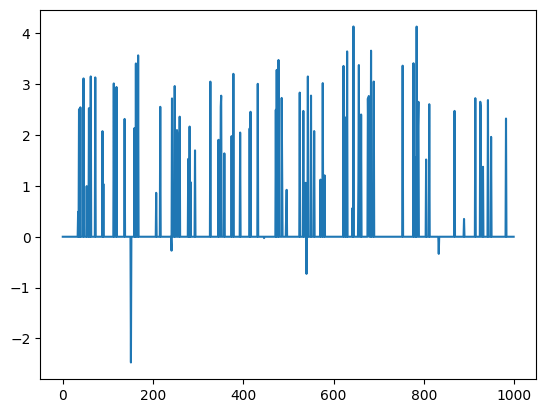

In [53]:
tw_values = generate_tweedie(week1[metric_column].mean() * 0.1, 1000)
tw_values[tw_values > 0] = np.log(tw_values[tw_values > 0])
ax = sns.lineplot(tw_values)

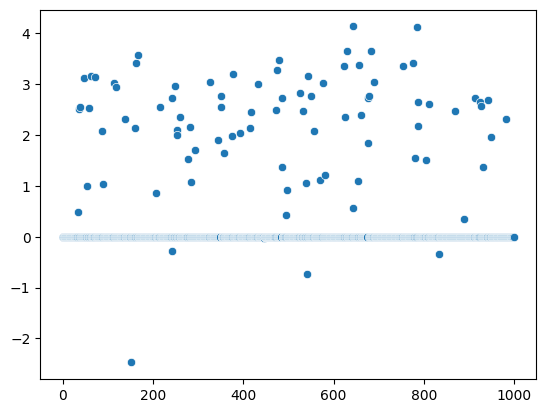

In [54]:
ax = sns.scatterplot(tw_values)

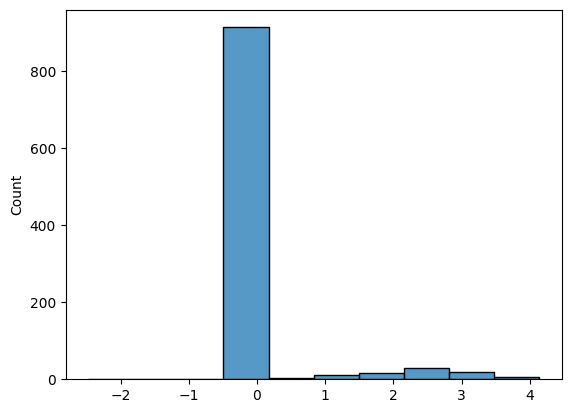

In [55]:
ax = sns.histplot(tw_values, bins=10)

In [56]:
metric_column = 'total_dur_ln'
tests_amounts = 100
amount_first_type_errors = 0
amount_second_type_errors = 0

group_size = 1000
alpha = 0.05
effect = 0.05

for exp_num in tqdm(range(tests_amounts)):
    # Checking for I type error
    splitter = Splitter(dataframe=week1, id_column='user_id')
    
    exp_data = splitter.run(method='hash', salt=f'2023-11-28_AB_Exp #{exp_num}', groups_size=group_size)
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Reject equality of means when it is true
    amount_first_type_errors += (pvalue < alpha)  

    # Checking for II type error
    mean_b = exp_data[exp_data.group == 'B'][metric_column].mean()

    # Let's add an effect
    tw_values = generate_tweedie(effect * mean_b, group_size)
    tw_values[tw_values > 0] = np.log(tw_values[tw_values > 0])
    
    exp_data.loc[exp_data.group == 'B', metric_column] += tw_values
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Do not reject the equality of averages when it is necessary to reject
    amount_second_type_errors += (pvalue > alpha)  

print(f'Empirical I type error: {amount_first_type_errors.loc[0] / tests_amounts}')
print(f'Empirical II type error: {amount_second_type_errors.loc[0] / tests_amounts}')

  0%|          | 0/100 [00:00<?, ?it/s]

Empirical I type error: 0.07
Empirical II type error: 0.87


Результаты слабые, расчеты на константном эффекте были гораздо оптимистичнее

Попробуем увеличить эффект

In [57]:
metric_column = 'total_dur_ln'
tests_amounts = 100
amount_first_type_errors = 0
amount_second_type_errors = 0

group_size = 1000
alpha = 0.05
effect = 0.15

for exp_num in tqdm(range(tests_amounts)):
    # Checking for I type error
    splitter = Splitter(dataframe=week1, id_column='user_id')
    
    exp_data = splitter.run(method='hash', salt=f'2023-11-28_AB_Exp #{exp_num}', groups_size=group_size)
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Reject equality of means when it is true
    amount_first_type_errors += (pvalue < alpha)  

    # Checking for II type error
    mean_b = exp_data[exp_data.group == 'B'][metric_column].mean()

    # Let's add an effect
    tw_values = generate_tweedie(effect * mean_b, group_size)
    tw_values[tw_values > 0] = np.log(tw_values[tw_values > 0])
    
    exp_data.loc[exp_data.group == 'B', metric_column] += tw_values
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Do not reject the equality of averages when it is necessary to reject
    amount_second_type_errors += (pvalue > alpha)  

print(f'Empirical I type error: {amount_first_type_errors.loc[0] / tests_amounts}')
print(f'Empirical II type error: {amount_second_type_errors.loc[0] / tests_amounts}')

  0%|          | 0/100 [00:00<?, ?it/s]

Empirical I type error: 0.07
Empirical II type error: 0.58


Результаты лучше, но все еще не очень, 46% мощность - неприемлемо

Попробуем увеличить эффект

In [58]:
metric_column = 'total_dur_ln'
tests_amounts = 100
amount_first_type_errors = 0
amount_second_type_errors = 0

group_size = 1000
alpha = 0.05
effect = 0.25

for exp_num in tqdm(range(tests_amounts)):
    # Checking for I type error
    splitter = Splitter(dataframe=week1, id_column='user_id')
    
    exp_data = splitter.run(method='hash', salt=f'2023-11-28_AB_Exp #{exp_num}', groups_size=group_size)
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Reject equality of means when it is true
    amount_first_type_errors += (pvalue < alpha)  

    # Checking for II type error
    mean_b = exp_data[exp_data.group == 'B'][metric_column].mean()

    # Let's add an effect
    tw_values = generate_tweedie(effect * mean_b, group_size)
    tw_values[tw_values > 0] = np.log(tw_values[tw_values > 0])
    
    exp_data.loc[exp_data.group == 'B', metric_column] += tw_values
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Do not reject the equality of averages when it is necessary to reject
    amount_second_type_errors += (pvalue > alpha)  

print(f'Empirical I type error: {amount_first_type_errors.loc[0] / tests_amounts}')
print(f'Empirical II type error: {amount_second_type_errors.loc[0] / tests_amounts}')

  0%|          | 0/100 [00:00<?, ?it/s]

Empirical I type error: 0.05
Empirical II type error: 0.35


Результаты лучше, но мощность все еще не очень, всего 66%

Попробуем увеличить группы

In [59]:
metric_column = 'total_dur_ln'
tests_amounts = 100
amount_first_type_errors = 0
amount_second_type_errors = 0

group_size = 20000
alpha = 0.05
effect = 0.05

for exp_num in tqdm(range(tests_amounts)):
    # Checking for I type error
    splitter = Splitter(dataframe=week1, id_column='user_id')
    
    exp_data = splitter.run(method='hash', salt=f'2023-11-28_AB_Exp #{exp_num}', groups_size=group_size)
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Reject equality of means when it is true
    amount_first_type_errors += (pvalue < alpha)  

    # Checking for II type error
    mean_b = exp_data[exp_data.group == 'B'][metric_column].mean()

    # Let's add an effect
    tw_values = generate_tweedie(effect * mean_b, group_size)
    tw_values[tw_values > 0] = np.log(tw_values[tw_values > 0])
    
    exp_data.loc[exp_data.group == 'B', metric_column] += tw_values
    
    tester = Tester(dataframe=exp_data, metrics=metric_column, column_groups='group')
    pvalue = tester.run(method='empiric', criterion='mw', metrics=metric_column, alternative='greater')['pvalue']
    # Do not reject the equality of averages when it is necessary to reject
    amount_second_type_errors += (pvalue > alpha)  

print(f'Empirical I type error: {amount_first_type_errors.loc[0] / tests_amounts}')
print(f'Empirical II type error: {amount_second_type_errors.loc[0] / tests_amounts}')

  0%|          | 0/100 [00:00<?, ?it/s]

Empirical I type error: 0.04
Empirical II type error: 0.1


Как итог видим, что Designer дает оптимистичные оценки, для эффекта в 5% при $\alpha = 0.05, \beta=0.1$ нужна выборка в 20000